# Thematic differences

DHH23 Parliament group

Author: Pontus H.

In [78]:
# Set the theme here
THEME = 'healthcare_GB'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [79]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

Set up the BERTopic pipeline

In [80]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [81]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-GB_2017-11-20-commons.u80,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Wallace, Robert Ben Lobban",M,-,I am grateful to my hon. Friend for giving me ...,Friend for giving me the opportunity to point...,-0.443359,658
1,ParlaMint-GB_2017-11-20-commons.u137,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,LAB,Labour,Opposition,"Lee, Karen Elizabeth",F,-,"From December, the Policing and Crime Act 2017...","In Lincolnshire, with around 750,000 resident...",-0.813965,543
2,ParlaMint-GB_2017-11-20-commons.u153,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Whately, Helen Olivia Bicknell",F,-,Women who have suffered a sexual assault are a...,Will my hon,0.339355,213
3,ParlaMint-GB_2017-11-20-commons.u154,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Atkins, Victoria",F,-,My hon. Friend has led a strong campaign for e...,Friend has led a strong campaign for ensuring...,0.591309,583
4,ParlaMint-GB_2017-11-20-commons.u244,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,LAB,Labour,Opposition,"Hardy, Emma Ann",F,-,"Last Thursday, senior NHS leaders told me abou...",NaN,-0.216431,372


In [82]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [83]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.1)

In [84]:
pd.Series(new_topics).value_counts()

-1      6488
 1      1203
 0      1186
 8      1103
 2      1079
        ... 
 123      76
 120      74
 118      74
 113      62
 121      59
Length: 125, dtype: int64

In [85]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [86]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [87]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 125
Number of topics before: 125


In [88]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1      23481
 105      642
 81       625
 77       597
 22       558
        ...  
 103       51
 18        51
 17        50
 74        50
 64        50
Length: 125, dtype: int64

In [89]:
topic_model.visualize_topics()

Topics over time

In [90]:
# Reference running time for this cell: 2min 30s
topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [91]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [92]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [93]:
# Brexit
topics_over_time[topics_over_time['Topic'] == 0]

,Topic,Words,Frequency,Timestamp,Name
1,0,"cafferkey, screening, ebola, protocols, 495",1,2015-01-02 05:54:14.400,0_vaccination_dose_variants_jcvi
94,0,"bio, globalisation, autocracies, dares, loyalties",2,2015-05-22 16:48:00.000,0_vaccination_dose_variants_jcvi
295,0,"eradicated, shortfalls, india, unicef, strategic",1,2016-02-22 02:24:00.000,0_vaccination_dose_variants_jcvi
394,0,"pattern, derbyshire, vaccinations, eligible, s...",1,2016-07-08 19:12:00.000,0_vaccination_dose_variants_jcvi
491,0,"padded, trolley, folk, awfully, worry",2,2016-11-23 12:00:00.000,0_vaccination_dose_variants_jcvi
603,0,"vaccinology, corporatised, manifestos, wiltshi...",1,2017-04-10 04:48:00.000,0_vaccination_dose_variants_jcvi
683,0,"meningitis, gpei, freshers, isabelle, eradicated",3,2017-08-25 21:36:00.000,0_vaccination_dose_variants_jcvi
783,0,"pharmacies, flu, visits, dispatch, box",1,2018-01-10 14:24:00.000,0_vaccination_dose_variants_jcvi
889,0,"hpv, debut, adolescent, immunisation, cancers",2,2018-05-28 07:12:00.000,0_vaccination_dose_variants_jcvi
993,0,"vaccinations, herd, indirect, gavi, complacency",3,2018-10-13 00:00:00.000,0_vaccination_dose_variants_jcvi


In [94]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

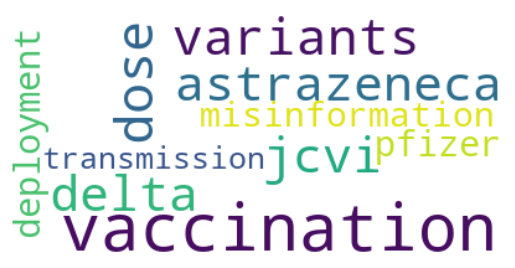

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [96]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [97]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['vaccination',
 'dose',
 'variants',
 'jcvi',
 'delta',
 'astrazeneca',
 'pfizer',
 'deployment',
 'misinformation',
 'transmission']

In [98]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
speech_topic_party.loc[speech_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
speech_topic_party.loc[speech_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
speech_topic_party.loc[speech_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,920,178,43,45
1,642,352,77,132
2,416,486,75,102
3,441,184,67,71
4,501,180,50,22
5,425,461,56,48
6,372,256,38,26
7,292,223,132,13
8,615,395,59,34


In [99]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,CON,LAB,OTHER,SNP
topic,,,,
0,17.7,6.0,6.6,8.2
1,12.3,12.0,11.9,24.1
2,8.0,16.5,11.6,18.6
3,8.5,6.2,10.3,13.0
4,9.6,6.1,7.7,4.0
5,8.2,15.7,8.6,8.8
6,7.1,8.7,5.9,4.7
7,5.6,7.6,20.3,2.4
8,11.8,13.4,9.1,6.2


In [100]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,CON,LAB,OTHER,SNP,keywords
topic,,,,,
0,17.7,6.0,6.6,8.2,"[vaccination, dose, variants, jcvi, delta, ast..."
1,12.3,12.0,11.9,24.1,"[furlough, coronavirus, hospitality, retention..."
2,8.0,16.5,11.6,18.6,"[trade, brexit, withdrawal, vote, rights, dire..."
3,8.5,6.2,10.3,13.0,"[forces, covenant, defence, mod, serving, afgh..."
4,9.6,6.1,7.7,4.0,"[radiotherapy, screening, pancreatic, stem, jo..."
5,8.2,15.7,8.6,8.8,"[chancellor, wage, fiscal, obr, billion, forec..."
6,7.1,8.7,5.9,4.7,"[maiden, speeches, predecessor, stoke, trent, ..."
7,5.6,7.6,20.3,2.4,"[abortions, ireland, 1967, foetal, supreme, hu..."
8,11.8,13.4,9.1,6.2,"[care, councils, integration, precept, elderly..."


In [101]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,CON,LAB,OTHER,SNP
0,0,77.6,15.0,3.6,3.8
1,1,53.4,29.3,6.4,11.0
2,2,38.6,45.0,7.0,9.5
3,3,57.8,24.1,8.8,9.3
4,4,66.5,23.9,6.6,2.9
5,5,42.9,46.6,5.7,4.8
6,6,53.8,37.0,5.5,3.8
7,7,44.2,33.8,20.0,2.0
8,8,55.8,35.8,5.3,3.1
9,9,63.4,25.0,5.7,6.0


Calculate mean sentiment for each topic per party

In [102]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,0.20,-0.23,-0.12,-0.41
1,0.25,-0.35,-0.15,-0.19
2,0.11,-0.29,-0.38,-0.42
3,0.29,-0.07,0.22,-0.01
4,0.29,-0.06,-0.08,0.11
5,0.10,-0.45,-0.20,-0.42
6,0.47,0.48,0.43,0.55
7,-0.03,-0.23,-0.31,-0.50
8,0.22,-0.44,-0.19,-0.36
